In [86]:
### code modified from kaggle.com/code/jeffaudi/aircraft-detection-with-yolov8/notebook
### Original author: JEFF FAUDI
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
import torch
import random
import numpy as np

seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

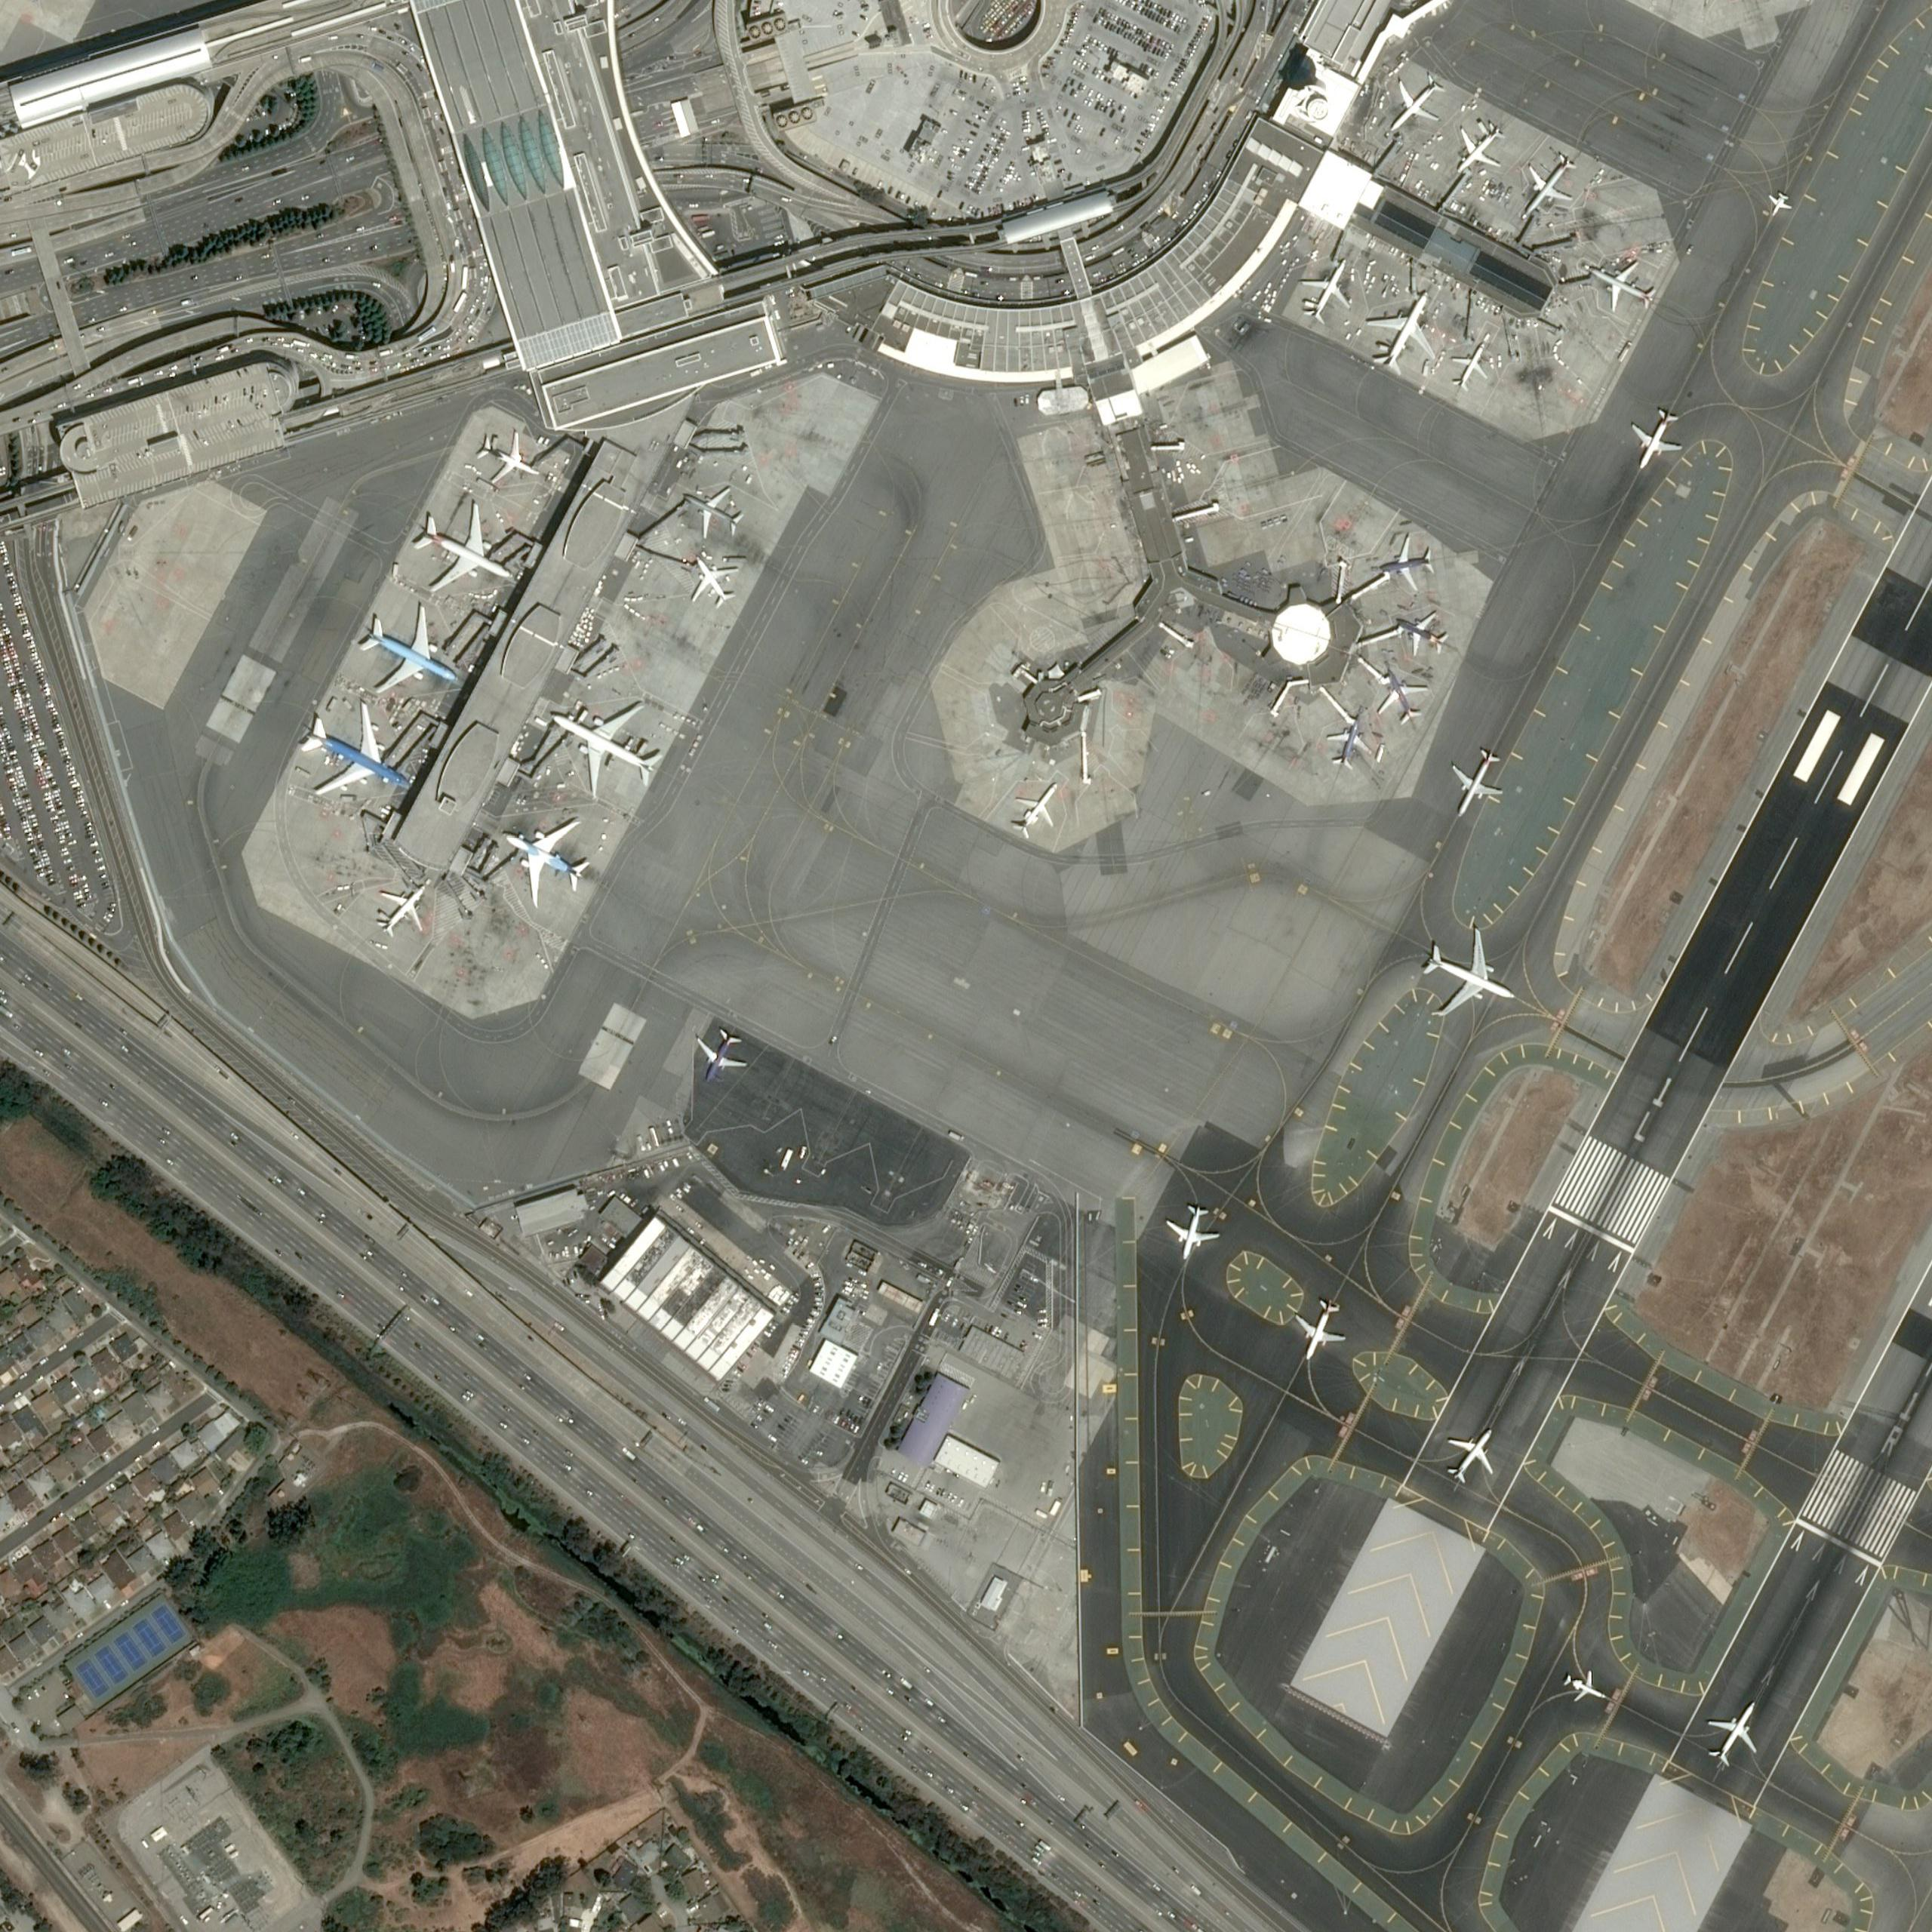

In [88]:
DATA_DIR = Path('../airbus_dataset')
img_list = list(DATA_DIR.glob('images/*.jpg'))
pickone = random.choice(img_list)
Image(pickone)

In [89]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

img = PIL.Image.open(pickone)
print(img.format, img.size, img.mode)
print(type(img))
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

Found 103 images files in ../airbus_dataset
JPEG (2560, 2560) RGB
<class 'PIL.JpegImagePlugin.JpegImageFile'>
Image size: (2560, 2560)
Num channels: 3


In [90]:
df = pd.read_csv(DATA_DIR / 'annotations.csv')
# convert a string record into a valid python object
def f(x): 
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv(DATA_DIR / "annotations.csv", 
                converters={'geometry': f})
df.head(10)

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane


In [91]:
def getBounds(geometry):
    try: 
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

def getWidth(bounds):
    try: 
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(xmax - xmin)
    except:
        return np.nan

def getHeight(bounds):
    try: 
        (xmin, ymin, xmax, ymax) = bounds
        return np.abs(ymax - ymin)
    except:
        return np.nan

# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'width'] = df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'height'] = df.loc[:,'bounds'].apply(getHeight)
df.head(10)

,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,"(594, 938, 657, 1012)",63,74
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane,"(451, 725, 524, 798)",73,73
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane,"(1543, 1437, 1614, 1497)",71,60
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane,"(1485, 1370, 1561, 1437)",76,67
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane,"(1968, 1624, 2053, 1687)",85,63
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane,"(1659, 1674, 1733, 1746)",74,72


In [92]:
# create a list of images used for validation
fold = 1
num_fold = 5
index = df['image_id'].unique()
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]
print(val_indexes)

['78099b50-f2b6-4319-b462-f33df2966c45.jpg' '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg' 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg' '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg' '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg' 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg' '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg' 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg' '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg' '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg' 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg' '014de911-7810-4f7d-8967-3e5402209f4a.jpg' 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg' '576827bc-a94a-4611-8820-f3d56e969151.jpg' '4e9164aa-532e-4b76-bce4-060b090da357.jpg' '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg' '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg' 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg' '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


In [93]:
import os 
import tqdm.notebook

# Create 512x512 tiles with 64 pix overlap
TILE_WIDTH = 224
TILE_HEIGHT = 224
TILE_OVERLAP = 28
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

TILES_DIR = {'train': Path(f'../airbus_dataset/{TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}/train/images/'),
             'val': Path(f'../airbus_dataset/{TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}/val/images/')}
for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

LABELS_DIR = {'train': Path(f'../airbus_dataset/{TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}/train/labels/'),
             'val': Path(f'../airbus_dataset/{TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}/val/labels/')}
for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

# Save one line in .txt file for each tag found inside the tile
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    x_max_trunc = min(x_max, width) 
    x_min_trunc = max(x_min, 0) 
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, height) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None
        
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)
            
for img_path in tqdm.notebook.tqdm(img_list):
    # Open image and related data
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Get annotations for image
    img_labels = df[df["image_id"] == img_path.name]
    #print(img_labels)

    # Count number of sections to make
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH + TILE_OVERLAP - 1) // TILE_WIDTH 
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT + TILE_OVERLAP - 1) // TILE_HEIGHT
    
    # Cut each tile
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            # print(x_start, y_start, x_end, y_end)

            folder = 'val' if img_path.name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")
                
            # Save if file doesn't exit
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_HEIGHT, TILE_WIDTH, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            # save labels
            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

  0%|          | 0/103 [00:00<?, ?it/s]

In [94]:
CONFIG = f"""
# train and val datasets (image directory or *.txt file with image paths)
train: {TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}_/train/
val: {TILE_WIDTH}x{TILE_HEIGHT}_overlap{TILE_OVERLAP}_percent{TRUNCATED_PERCENT}_/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("../airbus_dataset/data.yaml", "w") as f:
    f.write(CONFIG)

In [95]:
device_num = 1
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")

### get current directory
cwd = os.getcwd()
print("cwd: ", cwd)
### get parent directory
parent_dir = os.path.dirname(cwd)
print("parent_dir: ", parent_dir)

HOME = parent_dir + "/airbus_dataset/"

cwd:  /home/pl22767/project/dtac-dev/airbus_detection
parent_dir:  /home/pl22767/project/dtac-dev


In [96]:
### Yolo models from small to large: n, m, s, l, x
# !yolo task=detect mode=train model=yolov5s.pt data={HOME}data.yaml epochs=10 imgsz=512
# !yolo task=detect mode=train model=yolov8x.pt data={HOME}data.yaml epochs=10 imgsz=512

In [97]:
RESULT = parent_dir + "/airbus_detection"
# !ls ../airbus_detection/runs/detect/train10/

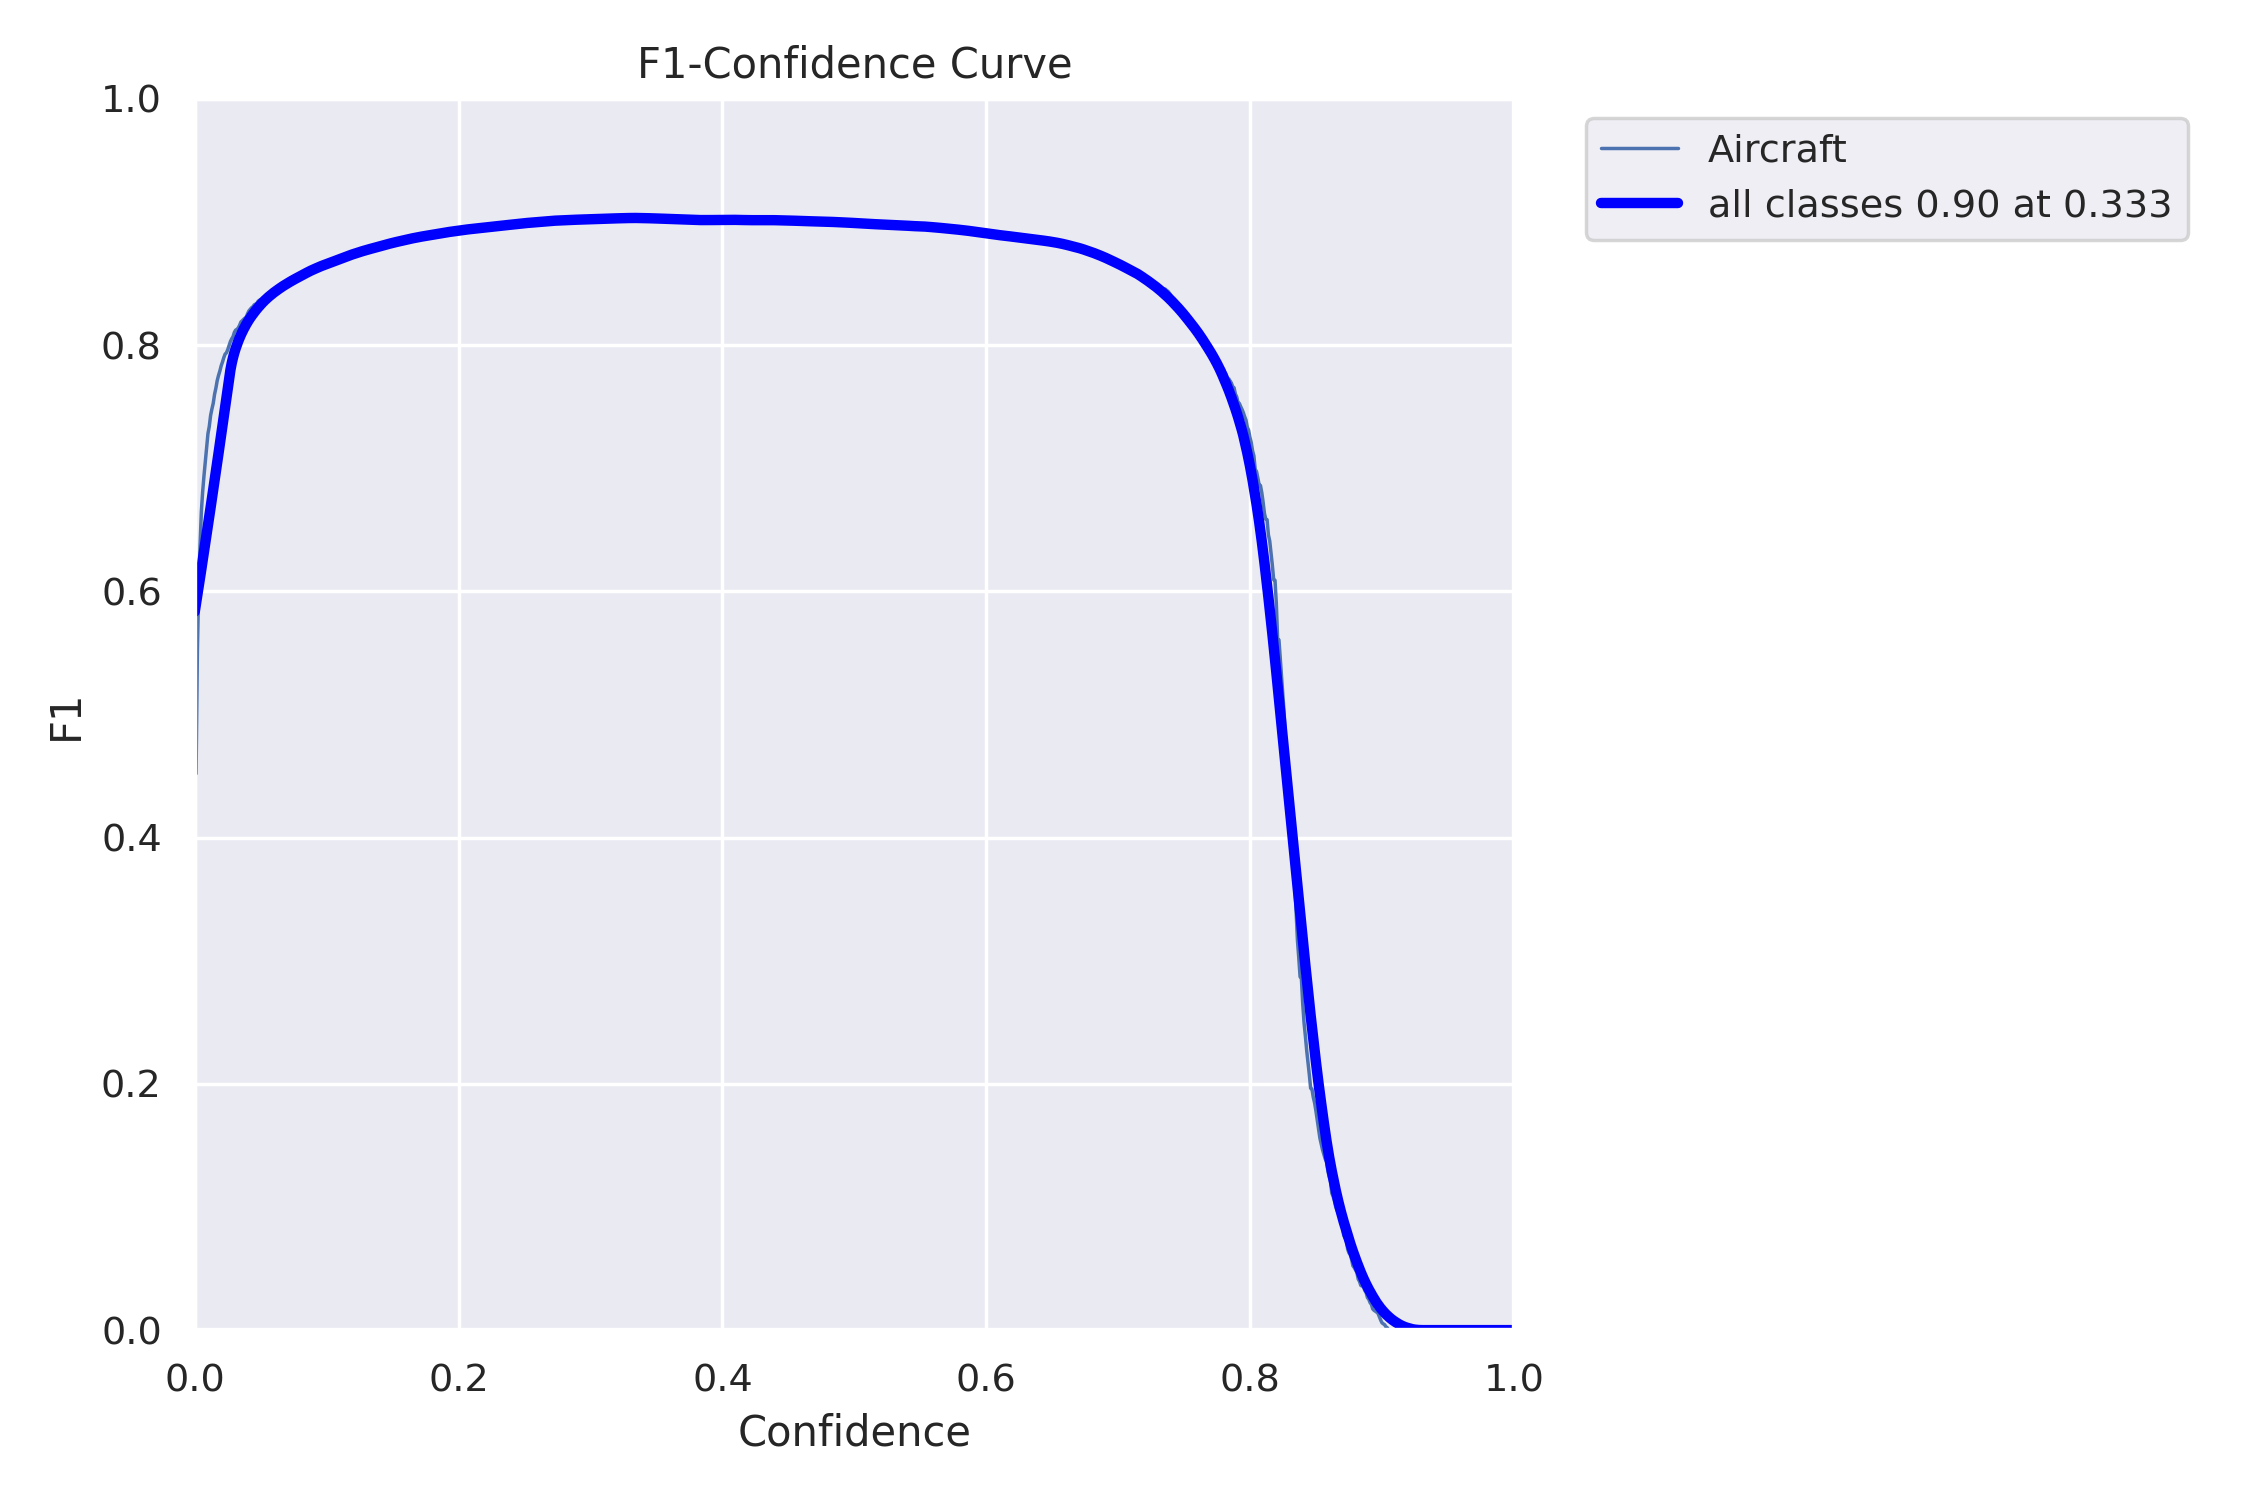

In [98]:
Image(filename=f'{RESULT}/runs/detect/train10/F1_curve.png', width=600)

In [99]:
import plotly.express as px
import pandas as pd

df = pd.read_csv(RESULT + "/runs/detect/train10/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

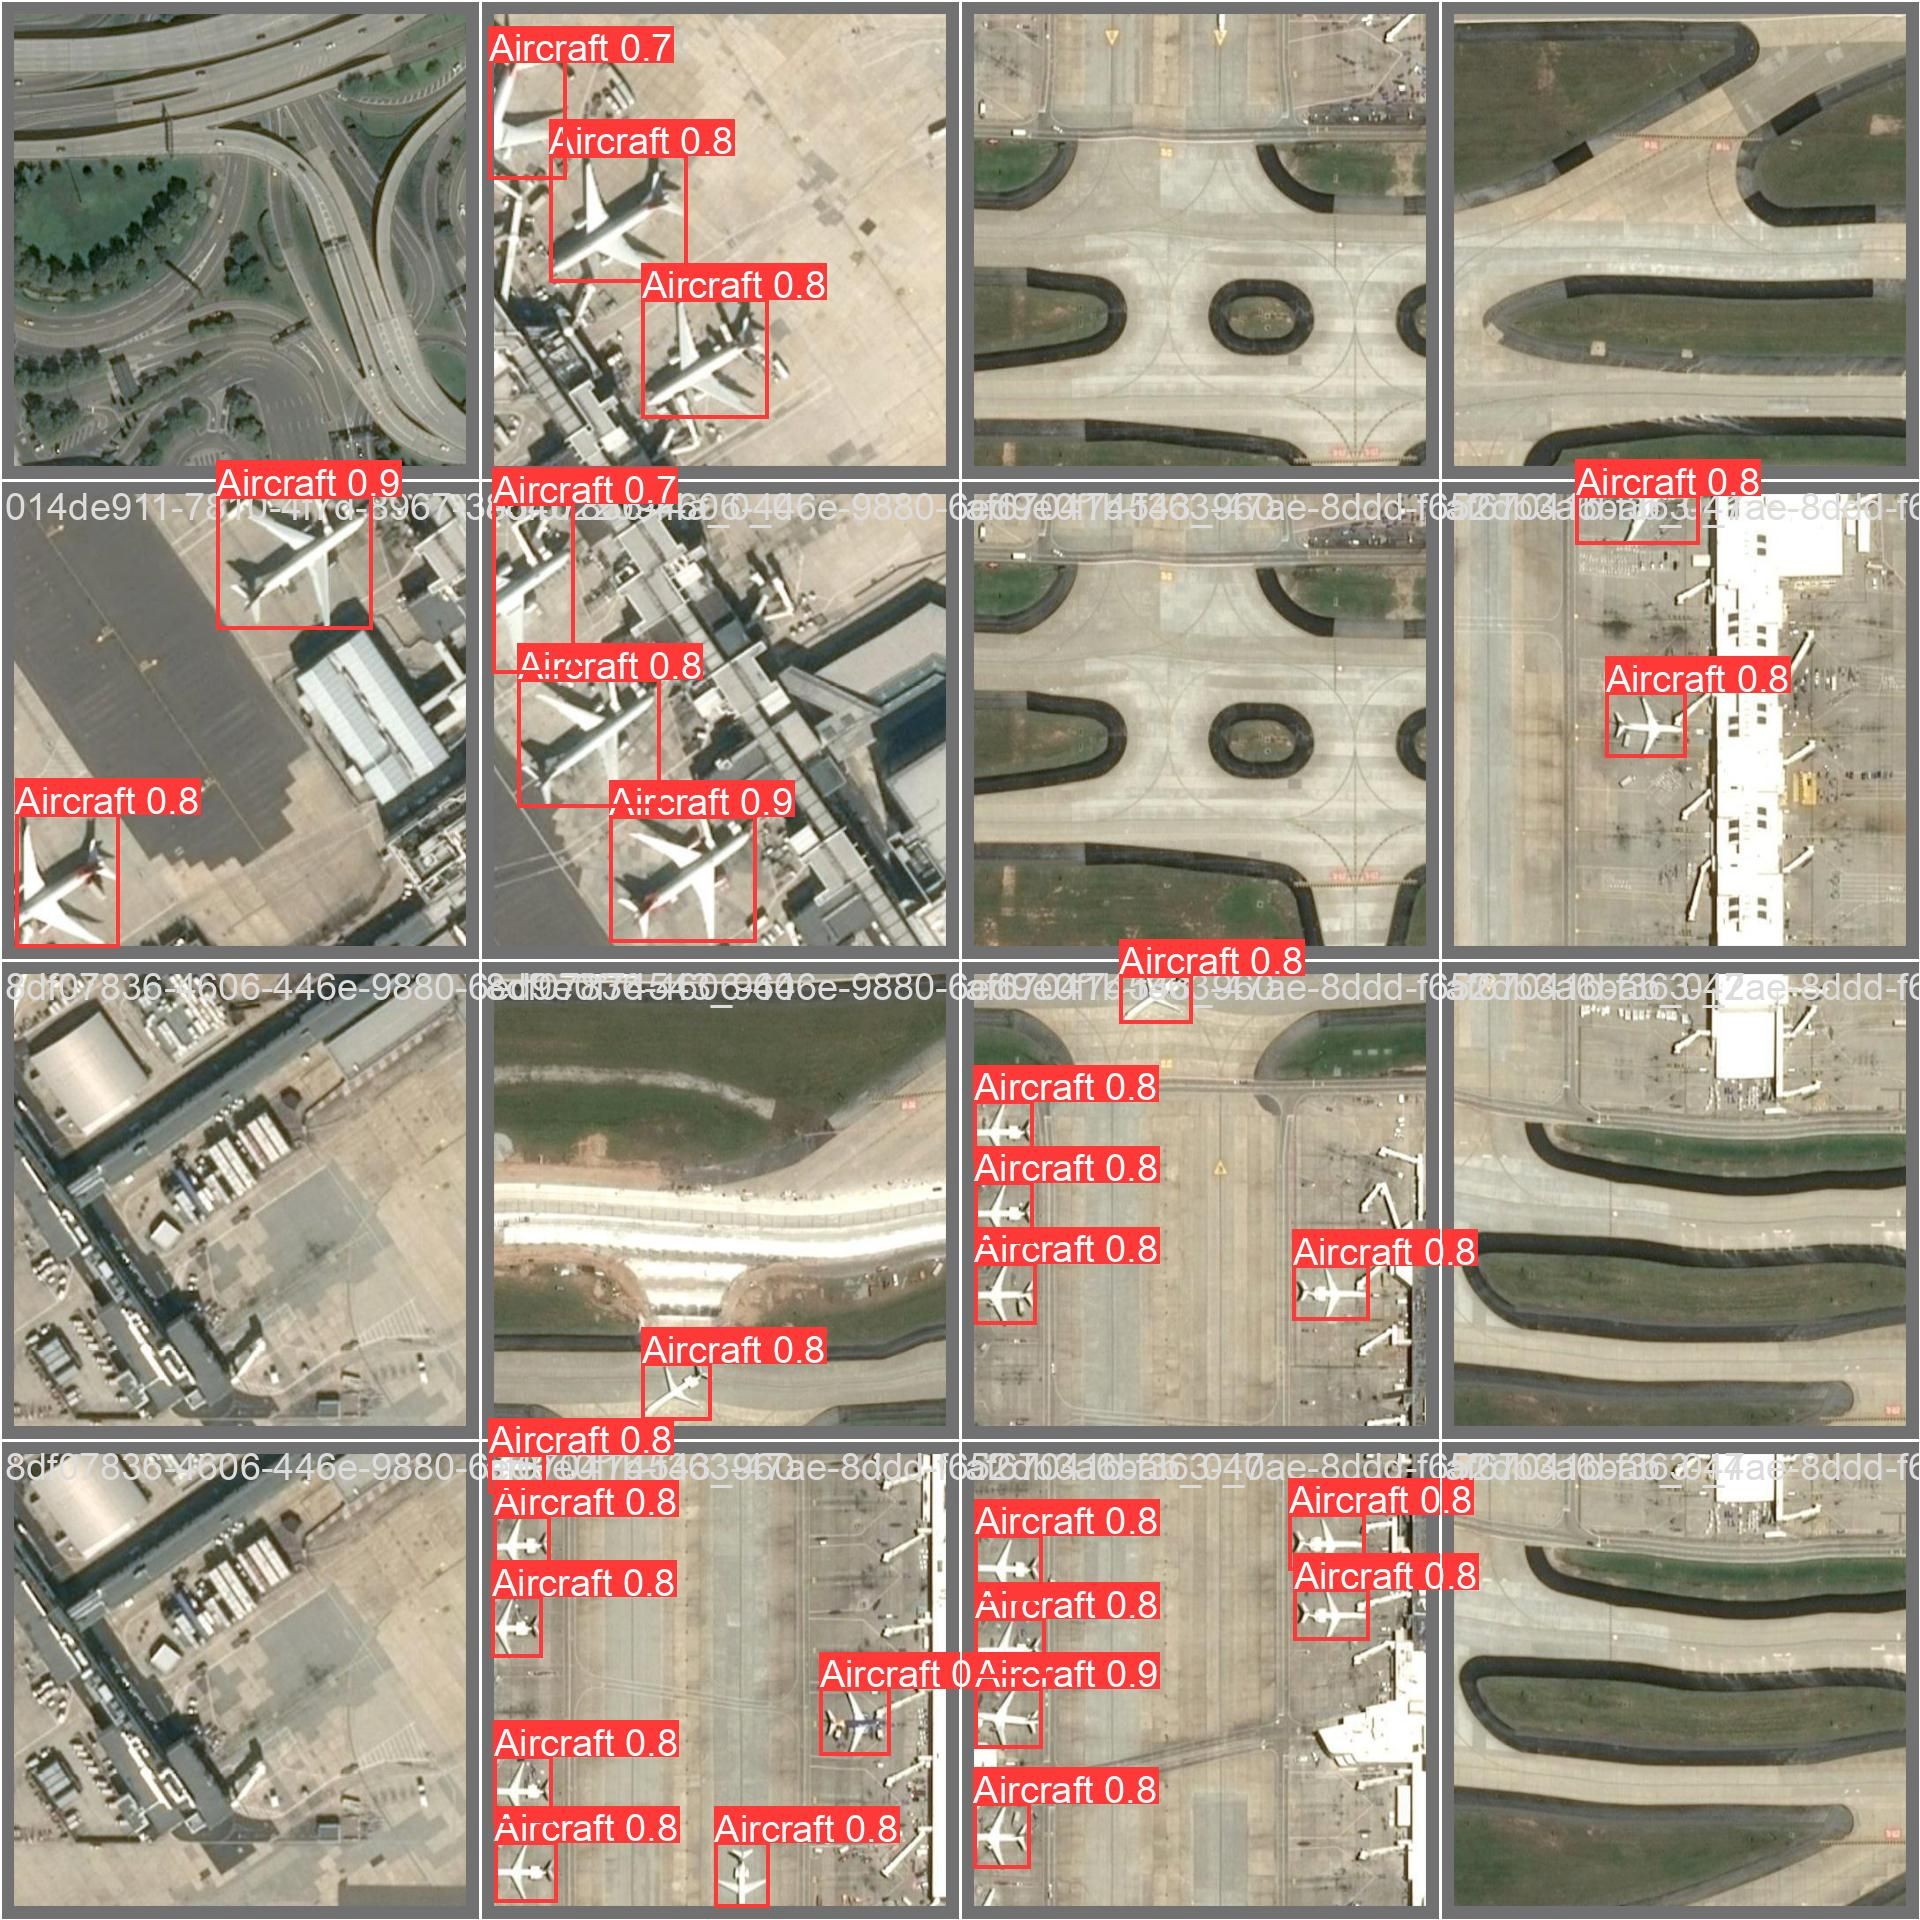

In [100]:
Image(filename=f'{RESULT}/runs/detect/train10/val_batch0_pred.jpg', width=1000)

In [101]:
!yolo task=detect mode=val model=/home/pl22767/project/dtac-dev/airbus_detection/runs/detect/train3/weights/best.pt data={HOME}/data.yaml

Ultralytics YOLOv8.0.50 🚀 Python-3.10.8 torch-1.13.1+cu117 CUDA:0 (NVIDIA RTX A5000, 24248MiB)
YOLOv5s summary (fused): 193 layers, 9111923 parameters, 0 gradients, 23.8 GFLOPs
val: Scanning /home/pl22767/project/dtac-dev/airbus_dataset/224x224_overlap28_pe
val: WARNING ⚠️ /home/pl22767/project/dtac-dev/airbus_dataset/224x224_overlap28_percent0.3_/val/7635d63c-6b97-4c9c-a7dc-27773d42ed4c_1764_420.jpg: 1 duplicate labels removed
val: New cache created: /home/pl22767/project/dtac-dev/airbus_dataset/224x224_overlap28_percent0.3_/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       3024       1303      0.787      0.586      0.682      0.404
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val10


(512, 512, 3) <class 'numpy.ndarray'>



0: 512x512 3 Aircrafts, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)


tensor([[0.84570, 0.59082, 0.30859, 0.29883],
        [0.45215, 0.19629, 0.33008, 0.34570],
        [0.73633, 0.89746, 0.39062, 0.20117]], device='cuda:0')
tensor([0.86581, 0.86216, 0.85715], device='cuda:0')
tensor([0., 0., 0.], device='cuda:0')
tensor([[354.00000, 226.00000, 512.00000, 379.00000,   0.86581,   0.00000],
        [147.00000,  12.00000, 316.00000, 189.00000,   0.86216,   0.00000],
        [277.00000, 408.00000, 477.00000, 511.00000,   0.85715,   0.00000]], device='cuda:0')


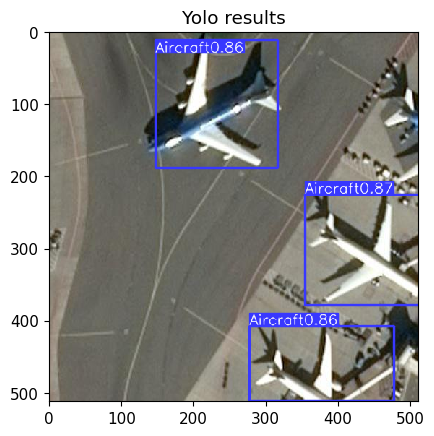

In [102]:
%matplotlib inline 
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchsummary import summary
from ultralytics import YOLO
import cv2
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from ultralytics.yolo.v8.detect.train import Loss

transform_img = A.Compose([
    A.Resize(width=256, height=256),
    A.Resize(width=512, height=512),
    ToTensorV2(p=1.0)
])


device_num = 1
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
task_model = YOLO("../airbus_detection/runs/detect/train/weights/best.pt")
task_model.verbose = False
img_path = "/home/pl22767/project/dtac-dev/airbus_dataset/512x512_overlap64_percent0.3_/train/3da0b873-fdde-4faf-9a85-021248c7dacf_448_448.jpg"
image = Image.open(img_path)
image = image.convert("RGB")
image = np.array(image)
# image = np.random.randint(0, 255, size=(512, 512, 3), dtype=np.uint8)
# image = transform_img(image=image)["image"]
print(image.shape, type(image))

results = task_model(image)
# print(task_model.names)
# model = task_model.model.to(device)
# output = model(image.float().to(device).unsqueeze(0))
# for i in output[1]:
#     print(i.shape)

for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    boxes.xyxy  # box with xyxy format, (N, 4)
    boxes.xywh  # box with xywh format, (N, 4)
    boxes.xyxyn  # box with xyxy format but normalized, (N, 4)
    boxes.xywhn  # box with xywh format but normalized, (N, 4)
    boxes.conf  # confidence score, (N, 1)
    boxes.cls  # cls, (N, 1)
    boxes.data  # raw bboxes tensor, (N, 6) or boxes.boxes 
    ### print out the results
    # print(boxes.xyxy)
    # print(boxes.xywh)
    # print(boxes.xyxyn)
    print(boxes.xywhn)
    print(boxes.conf)
    print(boxes.cls)
    print(boxes.data)

    res_plotted = result.plot()

plt.title("Yolo results")
plt.imshow(res_plotted, interpolation='nearest')
plt.show()

# loss_fn = Loss(model)